In [66]:
from pandas import read_csv, unique

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, auc
from tqdm import tqdm
from tensorflow import stack
from keras import initializers
from sklearn.model_selection import train_test_split 
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation, Input
from keras.layers import Conv1D, LSTM, Dropout, TimeDistributed, RepeatVector
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.ensemble import IsolationForest
from keras import regularizers
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [67]:
df = pd.read_csv("./Data/WISDM.csv", index_col=0)
df

,user-id,activity,timestamp,X,Y,Z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,9.000000,-1.570000,1.690000
1098200,19,Sitting,131623371431000,9.040000,-1.460000,1.730000
1098201,19,Sitting,131623411592000,9.080000,-1.380000,1.690000
1098202,19,Sitting,131623491487000,9.000000,-1.460000,1.730000


In [68]:
df.rename(columns={'activity': 'label'}, inplace=True)
df

,user-id,label,timestamp,X,Y,Z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,9.000000,-1.570000,1.690000
1098200,19,Sitting,131623371431000,9.040000,-1.460000,1.730000
1098201,19,Sitting,131623411592000,9.080000,-1.380000,1.690000
1098202,19,Sitting,131623491487000,9.000000,-1.460000,1.730000


In [69]:
df_sitting = df[df['label'] == 'Jogging'].sample(n=45000, random_state=42)
df_jogging = df[df['label'] == 'Sitting'].sample(n=45000, random_state=42)
len(df_sitting), len(df_jogging)

(45000, 45000)

In [70]:
df_train = pd.concat([df_sitting, df_jogging], axis=0)
df_train

,user-id,label,timestamp,X,Y,Z
110810,13,Jogging,0,0.00,0.00,0.000000
164275,6,Jogging,2694792247000,-0.46,-0.46,1.334794
813141,31,Jogging,23960721626000,19.08,18.35,2.910000
1002308,2,Jogging,9022662336000,3.06,-0.30,1.920000
815984,31,Jogging,24102851723000,-0.23,4.25,-4.710000
...,...,...,...,...,...,...
458469,35,Sitting,185642650000,5.05,6.78,5.630000
830097,31,Sitting,25015871376000,0.89,-0.23,9.700000
685016,4,Sitting,3624542339000,-7.16,-0.80,-6.890000
707332,30,Sitting,1498822307000,3.60,6.63,-6.970000


In [71]:
df_train['label'] = df_train['label'].replace({'Sitting': 0, 'Jogging': 1})
df_train

,user-id,label,timestamp,X,Y,Z
110810,13,1,0,0.00,0.00,0.000000
164275,6,1,2694792247000,-0.46,-0.46,1.334794
813141,31,1,23960721626000,19.08,18.35,2.910000
1002308,2,1,9022662336000,3.06,-0.30,1.920000
815984,31,1,24102851723000,-0.23,4.25,-4.710000
...,...,...,...,...,...,...
458469,35,0,185642650000,5.05,6.78,5.630000
830097,31,0,25015871376000,0.89,-0.23,9.700000
685016,4,0,3624542339000,-7.16,-0.80,-6.890000
707332,30,0,1498822307000,3.60,6.63,-6.970000


In [72]:
X_train, X_test = train_test_split(df_train, test_size=0.2, random_state=42)
X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=42)

X_train.shape, X_val.shape, X_test.shape

((57600, 6), (14400, 6), (18000, 6))

In [73]:
X_train

,user-id,label,timestamp,X,Y,Z
573825,20,0,58858602306000,-0.95,3.87,9.300000
577488,20,0,59041782360000,-0.65,4.60,9.110000
221807,27,0,12387722638000,3.15,9.43,1.266692
1050721,7,0,209292411592000,-6.13,-3.41,7.040000
739183,34,0,2004332255000,-3.68,-0.91,8.310000
...,...,...,...,...,...,...
583542,20,0,59344492291000,-4.67,3.11,8.240000
1097092,19,0,131567961580000,8.96,-0.76,2.260000
458317,35,0,178062297000,5.09,6.74,5.710000
538646,29,0,295702342000,7.46,2.26,6.510000


In [74]:
X_train = X_train[X_train.label == 0]
X_train = X_train.drop(['label', 'user-id', 'timestamp'], axis=1)

X_val = X_val[X_val.label == 0]
X_val = X_val.drop(['label', 'user-id', 'timestamp'], axis=1)

y_test = X_test['label']
X_test = X_test.drop(['label', 'user-id', 'timestamp'], axis=1)

X_train = X_train.values
X_val = X_val.values
X_test = X_test.values

In [75]:
# Normalize the above splits using the MinMaxScaler from the scikit learn package
scaler = MinMaxScaler()

# Make sure to only fit the scaler on the training data
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.transform(X_test)

In [80]:
NUM_COL = 3
#Setting the Hyperparameters

#learning_rate = 0.00001
learning_rate = 0.0001
batch_size = 512
epochs = 5
adam = Adam(learning_rate = learning_rate, beta_1 = 0.5)

In [81]:
# Defining the Generator network

def get_generator(optimizer):
    
    generator = Sequential()
    generator.add(Dense(64, input_dim=NUM_COL, kernel_initializer=initializers.glorot_normal(seed=42)))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(128))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(256))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(256))
    generator.add(Activation('tanh'))
       
    generator.add(Dense(512))
    generator.add(Activation('tanh'))
   
    generator.add(Dense(NUM_COL, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    
    return generator

In [82]:
##### Defining the Discriminator network

def get_discriminator(optimizer):
    
    discriminator = Sequential()
    
    discriminator.add(Dense(256, input_dim=NUM_COL, kernel_initializer=initializers.glorot_normal(seed=42)))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
       
    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Dense(1))
    discriminator.add(Activation('sigmoid'))
   
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

    return discriminator

In [83]:
def get_gan_network(discriminator, generator, optimizer,input_dim=NUM_COL):

    discriminator.trainable = False   
    gan_input = Input(shape=(input_dim,))  
    x = generator(gan_input)        
    gan_output = discriminator(x)
    
    gan = Model(inputs=gan_input, outputs=gan_output)    
    gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    
    
    return gan

In [84]:
#Training the GAN

#Calculating the number of batches based on the batch size
batch_count = X_train.shape[0] // batch_size
pbar = tqdm(total= epochs * batch_count)
gan_loss = []
discriminator_loss = []

#Inititalizing the network
generator = get_generator(adam)
discriminator = get_discriminator(adam)
gan = get_gan_network(discriminator, generator, adam,input_dim=NUM_COL)


for epoch in range(epochs):        
    for index in range(batch_count):        
        pbar.update(1)        
        # Creating a random set of input noise and images
        noise = np.random.normal(0, 1, size=[batch_size,NUM_COL])
        
        # Generate fake samples
        generated_images = generator.predict_on_batch(noise)
        
        #Obtain a batch of normal network packets
        image_batch = X_train[index * batch_size: (index + 1) * batch_size]
            
        X = np.vstack((generated_images,image_batch))       
        y_dis = np.ones(2*batch_size) 
        y_dis[:batch_size] = 0

        # Train discriminator
        discriminator.trainable = True
        d_loss= discriminator.train_on_batch(X, y_dis)

        # Train generator
        noise = np.random.uniform(0, 1, size=[batch_size, NUM_COL])
        y_gen = np.ones(batch_size)
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gen)
        
        #Record the losses
        discriminator_loss.append(d_loss)
        gan_loss.append(g_loss)
        
    print("Epoch %d Batch %d/%d [D loss: %f] [G loss:%f]" % (epoch,index,batch_count, d_loss, g_loss))              

  1%|▏         | 1/70 [07:46<8:56:47, 466.78s/it]


Epoch 0 Batch 55/56 [D loss: 0.549660] [G loss:0.649612]


Epoch 1 Batch 55/56 [D loss: 0.669958] [G loss:0.896234]


Epoch 2 Batch 55/56 [D loss: 0.592743] [G loss:0.510555]


 62%|██████▏   | 173/280 [00:08<00:04, 23.33it/s]

Epoch 3 Batch 55/56 [D loss: 0.580806] [G loss:1.052714]


Epoch 4 Batch 55/56 [D loss: 0.456017] [G loss:0.626267]


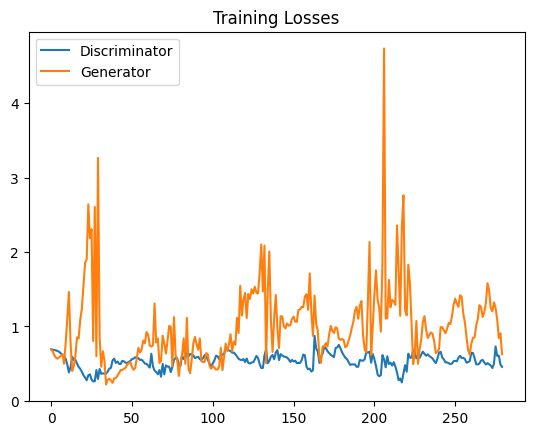

In [85]:
fig, ax = plt.subplots()
plt.plot(discriminator_loss, label='Discriminator')
plt.plot(gan_loss, label='Generator')
plt.title("Training Losses")
plt.legend()

In [86]:
# Predictions on the test set

nr_batches_test = np.ceil(X_test.shape[0] // batch_size).astype(np.int32)

results =[]

for t in range(nr_batches_test +1):    
        ran_from = t * batch_size
        ran_to = (t + 1) * batch_size
        image_batch = X_test[ran_from:ran_to]             
        tmp_rslt = discriminator.predict(x=image_batch,batch_size=128,verbose=0)        
        results = np.append(results, tmp_rslt)   

In [87]:
y2 = y_test.to_numpy()
pd.options.display.float_format = '{:20,.7f}'.format
results_df = pd.concat([pd.DataFrame(results),pd.DataFrame(y2)], axis=1)
results_df.columns = ['results','y_test']
print ('Mean score for Normal data :', results_df.loc[results_df['y_test'] == 1, 'results'].mean() )
print ('Mean score for Fall data :', results_df.loc[results_df['y_test'] == 0, 'results'].mean())

Mean score for Normal data : 0.33343494039127103
Mean score for Fall data : 0.43208987353263584


In [88]:
#Obtaining the lowest 1% score
per = np.percentile(results,1)
y_pred = results.copy()
y_pred = np.array(y_pred)

#Thresholding based on the score
inds = (y_pred > per)
inds_comp = (y_pred <= per)
y_pred[inds] = 0
y_pred[inds_comp] = 1

In [89]:
precision, recall, f1,_ = precision_recall_fscore_support(y_test,y_pred,average='binary')
print ('Accuracy Score :',accuracy_score(y_test, y_pred) )
print ('Precision :',precision )
print ('Recall :',recall )
print ('F1 :',f1 )

Accuracy Score : 0.5097777777777778
Precision : 1.0
Recall : 0.019991115059973346
F1 : 0.039198606271777


Confusion Matrix :


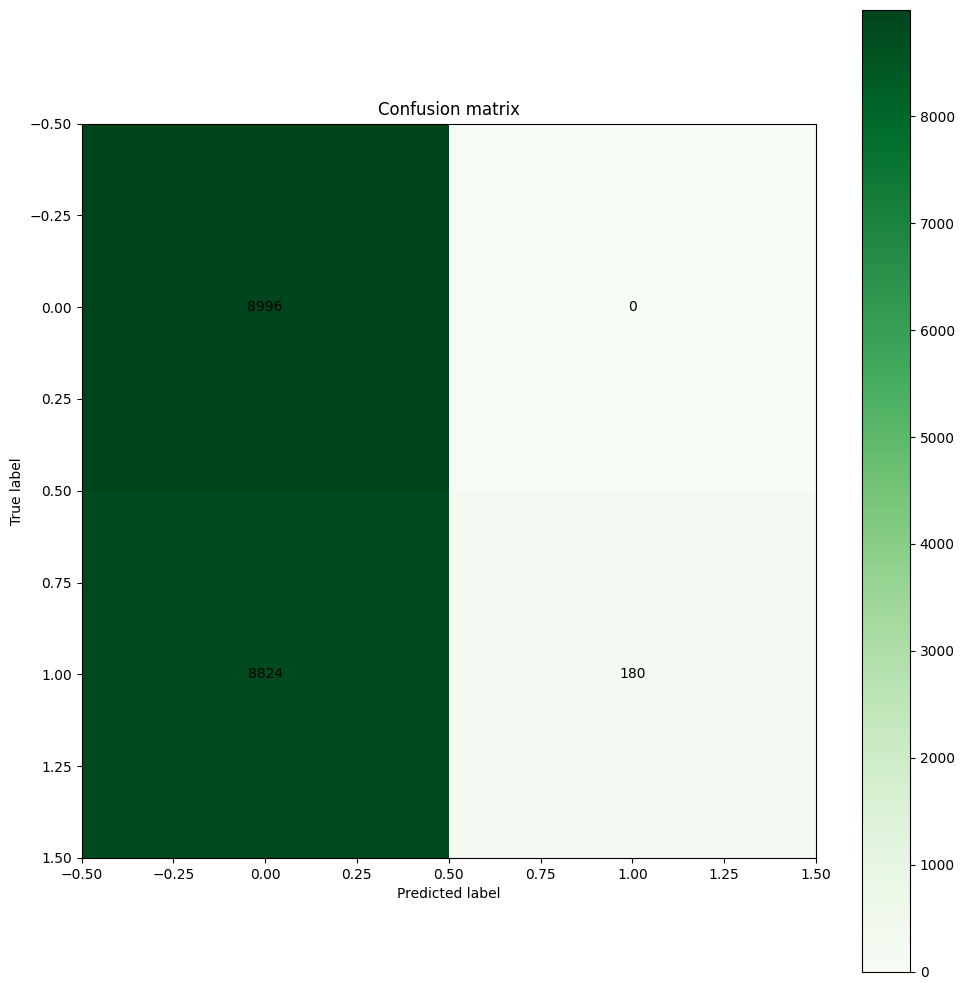

In [90]:
cm = confusion_matrix(y_test, y_pred)

print ('Confusion Matrix :')

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Greens):
    plt.figure(figsize=(10,10),)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plot_confusion_matrix(cm)

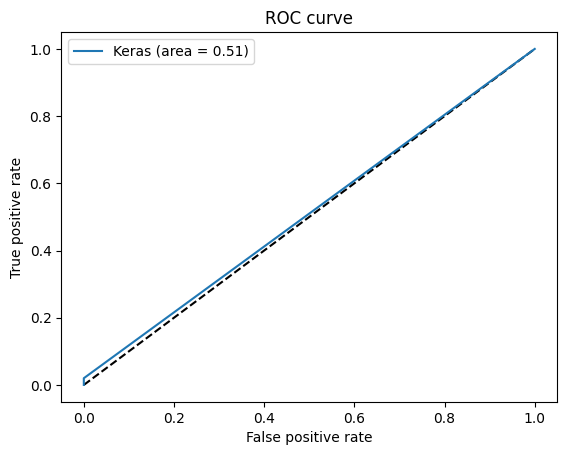

In [91]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.2f})'.format(auc_keras))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()